In [5]:
if 'libraries_imported' not in globals():
    libraries_imported = False

if libraries_imported == False:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from datetime import datetime, timedelta
    from datetime import datetime
    # from scipy.interpolate import make_interp_splines
    import plotly.graph_objects as go
    from scipy.signal import butter, filtfilt
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    from keras_tuner import RandomSearch, HyperModel
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    from keras_tuner import RandomSearch, HyperModel
    from tensorflow.keras.layers import Input
    import sys
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    import numpy as np
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import RobustScaler
    import tensorflow as tf
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from sklearn.preprocessing import RobustScaler
    import joblib
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    from sklearn.utils.class_weight import compute_class_weight
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import joblib
    import tensorflow as tf
    from sklearn.preprocessing import RobustScaler
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    import numpy as np
    import pandas as pd
    import joblib
    import tensorflow as tf
    from sklearn.model_selection import train_test_split
    from imblearn.over_sampling import SMOTE
    import numpy as np
    import pandas as pd
    import joblib
    import os
    from collections import Counter
    import matplotlib.pyplot as plt
    from sklearn.metrics import (
        accuracy_score, precision_recall_fscore_support,
        confusion_matrix, ConfusionMatrixDisplay
    )
    from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
    from sklearn.preprocessing import RobustScaler
    from imblearn.over_sampling import SMOTE
    from xgboost import XGBClassifier


    # # Display the first few rows
    # import ace_tools as tools  # Importing display tool


Inspect Feature importances


Basic feature engineering -- Add mvoing averages


In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt

# =============================
# Constants
# =============================
DROP_COLUMNS_LIVE_ONLY = ["h2s_ppm", "t1_cod", "t1_olr", "fostac"]

# =============================
# Setup portable directories
# =============================
BASE_DIR = Path.cwd()
MODEL_DIR = BASE_DIR / "model_params"
RESULTS_DIR = BASE_DIR / "results"

MODEL_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# =============================
# Dataset 1
# =============================
dataset1_df = pd.read_csv("datasets/s_dataset1.csv")

# Detect a date-like column
candidates = [c for c in ["datetime", "date", "day_number"] if c in dataset1_df.columns]
if not candidates:
    raise ValueError("No 'date', 'datetime', or 'day_number' column found in dataset 1.")
src_col = candidates[0]

# Build a clean 'date' column
if src_col == "day_number":
    base_date = pd.Timestamp("2020-01-01")  # adjust as needed
    dataset1_df["date"] = base_date + pd.to_timedelta(dataset1_df[src_col], unit="D")
else:
    dataset1_df["date"] = pd.to_datetime(dataset1_df[src_col], dayfirst=True, errors="coerce")

# Drop unwanted columns except the final 'date'
cols_to_drop = ["index", "f/m_ratio", "fos", "tac"]
dataset1_df.drop(columns=[c for c in cols_to_drop if c in dataset1_df.columns], inplace=True)

# Drop live-only columns (if present)
dataset1_df.drop(
    columns=[c for c in DROP_COLUMNS_LIVE_ONLY if c in dataset1_df.columns],
    inplace=True
)

if src_col != "date" and src_col in dataset1_df.columns:
    dataset1_df.drop(columns=[src_col], inplace=True)

dataset1_df = dataset1_df.drop_duplicates()

# =============================
# Dataset 2
# =============================
dataset2_df = pd.read_csv("datasets/c_dataset2.csv")

# Detect a date-like column
candidates = [c for c in ["datetime", "date", "day_number"] if c in dataset2_df.columns]
if not candidates:
    raise ValueError("No 'date', 'datetime', or 'day_number' column found in dataset 2.")
src_col = candidates[0]

# Convert to datetime or compute from day_number
if src_col == "day_number":
    base_date = pd.Timestamp("2020-01-01")  # adjust as needed
    dataset2_df["date"] = base_date + pd.to_timedelta(dataset2_df[src_col], unit="D")
else:
    dataset2_df["date"] = pd.to_datetime(dataset2_df[src_col], dayfirst=True, errors="coerce")

# Group and clean
dataset2_df = dataset2_df.groupby("date").mean(numeric_only=True)
dataset2_df = dataset2_df.drop_duplicates()
dataset2_df.reset_index(inplace=True)

# Drop live-only columns (if present)
dataset2_df.drop(
    columns=[c for c in DROP_COLUMNS_LIVE_ONLY if c in dataset2_df.columns],
    inplace=True
)

# Scale methane percentage if present
if "methane_percentage" in dataset2_df.columns:
    dataset2_df["methane_percentage"] *= 100


In [7]:
# ------------------------------
# Imports
# ------------------------------
import os
import random
import joblib
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE
import xgboost as xgb


# ------------------------------
# Config
# ------------------------------
TARGET = "eq_cod"
DATE_COL = "date"
OUTDIR = "transfer_learning_model_params"

# Percentages of each dataset to keep (e.g. 0.1 = 10%)
PRETRAIN_PCTS = [0.6, 0.7]

# Bin labels (fixed order)
CLASS_LABELS = ["LL", "ML", "MH", "HH"]

# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

MAX_FOLDS = 10

# Binning alignment config
BIN_ROUND_BASE = 500
EPS = 1e-9


# ------------------------------
# Helpers
# ------------------------------
def keep_random_percent(df, keep_percent, seed=SEED):
    if keep_percent >= 1.0:
        return df.copy()
    n_keep = max(1, int(len(df) * keep_percent))
    return df.sample(n=n_keep, random_state=seed).reset_index(drop=True)


def round_to_nearest(x, base=500):
    return base * round(float(x) / base)


def make_bins_from_dataset(df, target_col, n_bins=4, base=BIN_ROUND_BASE):
    dmin = float(df[target_col].min())
    dmax = float(df[target_col].max())

    bins = np.linspace(dmin, dmax, n_bins + 1)

    if base is not None and base > 0:
        bins = np.array([round_to_nearest(b, base) for b in bins], dtype=float)
        bins[0] = min(bins[0], dmin)
        bins[-1] = max(bins[-1], dmax)

    for i in range(1, len(bins)):
        if bins[i] <= bins[i - 1]:
            bins[i] = bins[i - 1] + EPS

    bins[-1] = max(bins[-1], dmax + EPS)

    return bins


def ensure_dir(path):
    os.makedirs(path, exist_ok=True)


def artifacts_exist(dataset_tag):
    base = os.path.join(OUTDIR, dataset_tag)
    return (
        os.path.exists(os.path.join(base, f"{dataset_tag}_best_model.pkl"))
        and os.path.exists(os.path.join(base, f"{dataset_tag}_scaler.pkl"))
        and os.path.exists(os.path.join(base, f"{dataset_tag}_feature_cols.pkl"))
        and os.path.exists(os.path.join(base, f"{dataset_tag}_bins.npy"))
        and os.path.exists(os.path.join(base, f"{dataset_tag}_labels.pkl"))
    )


# ------------------------------
# Main training pipeline
# ------------------------------
def run_pipeline_for_dataset(df, dataset_tag, keep_percent=1.0):
    print(f"\n=== Running pipeline for {dataset_tag} (keep_percent={keep_percent}) ===")

    if DATE_COL not in df.columns:
        raise ValueError(f"[{dataset_tag}] Missing date column '{DATE_COL}'")
    if TARGET not in df.columns:
        raise ValueError(f"[{dataset_tag}] Missing target column '{TARGET}'")

    df = df.sort_values(DATE_COL).reset_index(drop=True)

    df = keep_random_percent(df, keep_percent)
    df = df.ffill()
    df = df.dropna(subset=[TARGET]).copy()

    bins = make_bins_from_dataset(df, TARGET, n_bins=4)
    labels = CLASS_LABELS

    df["fostac_category"] = pd.cut(
        df[TARGET], bins=bins, labels=labels, include_lowest=True
    )
    df["fostac_category"] = (
        df["fostac_category"]
        .astype("category")
        .cat.set_categories(labels, ordered=True)
    )
    df.dropna(subset=["fostac_category"], inplace=True)

    X = df.select_dtypes(include=[np.number]).drop(columns=[TARGET])
    feature_cols = list(X.columns)

    y = pd.Series(df["fostac_category"].cat.codes)

    # ============================================================
    # CHECK 1: sampled data must contain all 4 classes
    # ============================================================
    if len(np.unique(y)) < len(CLASS_LABELS):
        print(
            f"[{dataset_tag}] SKIP: sampled data missing classes. "
            f"Found={sorted(np.unique(y))}"
        )
        return

    print(f"[{dataset_tag}] Class distribution (sampled): {Counter(y)}")

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    # ============================================================
    # CHECK 2: training split must contain all 4 classes
    # ============================================================
    if len(np.unique(y_train)) < len(CLASS_LABELS):
        print(
            f"[{dataset_tag}] SKIP: training split missing classes. "
            f"Found={sorted(np.unique(y_train))}"
        )
        return

    print(f"[{dataset_tag}] Class distribution (train): {Counter(y_train)}")

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    counts = Counter(y_train)
    min_count = min(counts.values())

    if min_count >= 2:
        sm = SMOTE(random_state=SEED)
        X_train_scaled, y_train = sm.fit_resample(X_train_scaled, y_train)
        y_train = pd.Series(y_train)
        print(f"[{dataset_tag}] SMOTE applied: {Counter(y_train)}")
    else:
        print(f"[{dataset_tag}] SMOTE skipped")

    param_grid = [
        {"max_depth": 3, "learning_rate": 0.1, "n_estimators": 200, "subsample": 0.8, "colsample_bytree": 0.8},
        {"max_depth": 4, "learning_rate": 0.08, "n_estimators": 300, "subsample": 0.9, "colsample_bytree": 0.9},
        {"max_depth": 5, "learning_rate": 0.05, "n_estimators": 400, "subsample": 0.9, "colsample_bytree": 0.9},
    ]

    n_splits = min(MAX_FOLDS, min_count)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    best_params = None
    best_score = -np.inf

    for params in param_grid:
        scores = []
        for tr, te in skf.split(X_train_scaled, y_train):
            model = xgb.XGBClassifier(
                objective="multi:softprob",
                num_class=4,
                random_state=SEED,
                eval_metric="mlogloss",
                **params,
            )
            model.fit(X_train_scaled[tr], y_train.iloc[tr])
            preds = model.predict(X_train_scaled[te])
            scores.append(accuracy_score(y_train.iloc[te], preds))

        score = float(np.mean(scores))
        print(f"[{dataset_tag}] Params {params} -> CV acc {score:.4f}")

        if score > best_score:
            best_score = score
            best_params = params

    print(f"[{dataset_tag}] Best params: {best_params}")

    best_model = xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=4,
        random_state=SEED,
        eval_metric="mlogloss",
        **best_params,
    )
    best_model.fit(X_train_scaled, y_train)

    val_preds = best_model.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_preds)
    print(f"[{dataset_tag}] Holdout accuracy: {val_acc:.4f}")

    base = os.path.join(OUTDIR, dataset_tag)
    ensure_dir(base)

    joblib.dump(best_model, os.path.join(base, f"{dataset_tag}_best_model.pkl"))
    joblib.dump(scaler, os.path.join(base, f"{dataset_tag}_scaler.pkl"))
    joblib.dump(feature_cols, os.path.join(base, f"{dataset_tag}_feature_cols.pkl"))
    joblib.dump(feature_cols, os.path.join(base, f"{dataset_tag}_features.pkl"))
    np.save(os.path.join(base, f"{dataset_tag}_bins.npy"), bins)
    joblib.dump(labels, os.path.join(base, f"{dataset_tag}_labels.pkl"))

    print(f"[{dataset_tag}] Saved artifacts → {base}")


# ------------------------------
# Driver
# ------------------------------
for pct in PRETRAIN_PCTS:
    d1_tag = f"D1_p{int(pct * 100)}"
    d2_tag = f"D2_p{int(pct * 100)}"

    if not artifacts_exist(d1_tag):
        run_pipeline_for_dataset(dataset1_df, d1_tag, keep_percent=pct)
    else:
        print(f"[{d1_tag}] Artifacts already exist, skipping.")

    if not artifacts_exist(d2_tag):
        run_pipeline_for_dataset(dataset2_df, d2_tag, keep_percent=pct)
    else:
        print(f"[{d2_tag}] Artifacts already exist, skipping.")



=== Running pipeline for D1_p60 (keep_percent=0.6) ===
[D1_p60] Class distribution (sampled): Counter({1: 35, 3: 20, 2: 14, 0: 10})
[D1_p60] Class distribution (train): Counter({1: 28, 3: 16, 2: 11, 0: 8})
[D1_p60] SMOTE applied: Counter({3: 28, 1: 28, 0: 28, 2: 28})
[D1_p60] Params {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8} -> CV acc 0.7768
[D1_p60] Params {'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.9} -> CV acc 0.7768
[D1_p60] Params {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 400, 'subsample': 0.9, 'colsample_bytree': 0.9} -> CV acc 0.7679
[D1_p60] Best params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8}
[D1_p60] Holdout accuracy: 0.5000
[D1_p60] Saved artifacts → transfer_learning_model_params/D1_p60

=== Running pipeline for D2_p60 (keep_percent=0.6) ===
[D2_p60] Class distribution (sampled): Co

In [8]:
# ===== Baseline (transfer learning + scaler switchable) =====
# Random train/validation split (no temporal ordering)
# Updated: sweep ONLY pretrained variants that exist on disk

import os, gc, random
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# ------------------ Config ------------------
OUTDIR_BASE = "transfer_learning_model_params/baseline"
os.makedirs(OUTDIR_BASE, exist_ok=True)

BASE_PRETRAIN_DIR = "transfer_learning_model_params"

RANDOM_STATE = 42
RANDOM_STATES = [1, 7, 13, 42, 99]

TARGET = "eq_cod"
N_BINS = 4
BIN_BASE = 500
TRAIN_RATIO = 0.50
CLASS_LABELS = ["LL", "ML", "MH", "HH"]

DROP_COLUMNS_LIVE_ONLY = ["h2s_ppm", "t1_cod", "t1_olr", "fostac"]

# NEW: Pretrain variants to try (must exist on disk from your "pretrain bank" script)
# (kept for reference; we will override the sweep by scanning the folder)
PRETRAIN_PERCENTS = [5, 10, 20, 40, 60, 80, 100]

# ------------------ Switches ------------------
ENABLE_TRANSFER_LEARNING = True
ENABLE_PRETRAINED_SCALER = True
ADDITIONAL_ESTIMATORS = 150

if ENABLE_TRANSFER_LEARNING and not ENABLE_PRETRAINED_SCALER:
    raise ValueError(
        "ENABLE_TRANSFER_LEARNING=True requires ENABLE_PRETRAINED_SCALER=True"
    )

# ------------------ Helpers ------------------
def round_to_nearest(x, base=500):
    return int(base * round(float(x) / base))

def random_param_sample(grid):
    return {k: random.choice(v) for k, v in grid.items()}

def build_design_matrix(df, feature_names):
    cols = []
    for name in feature_names:
        if name in df.columns:
            cols.append(df[name])
        else:
            cols.append(pd.Series(0.0, index=df.index, name=name))
    return pd.concat(cols, axis=1)

def bin_and_encode(df, target_col, n_bins=4, base=500, class_labels=None):
    if class_labels is None:
        class_labels = ["LL", "ML", "MH", "HH"]

    vmin, vmax = df[target_col].min(), df[target_col].max()
    bins = np.linspace(vmin, vmax, n_bins + 1)
    bins = [round_to_nearest(b, base) for b in bins]
    bins[0] = min(bins[0], vmin)
    bins[-1] = max(bins[-1], vmax)

    df = df.copy()
    df["target_label"] = pd.cut(
        df[target_col], bins=bins, labels=class_labels, include_lowest=True
    )
    df = df.dropna(subset=["target_label"])
    df["target_label"] = (
        df["target_label"]
        .astype("category")
        .cat.set_categories(class_labels, ordered=True)
    )
    return df, df["target_label"].cat.codes, bins

def prepare_df_for_baseline(raw_df, dayfirst=True):
    df = raw_df.copy()
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=dayfirst)

    df = df.drop(columns=[c for c in DROP_COLUMNS_LIVE_ONLY if c in df.columns])

    df = df.ffill()
    return df.dropna(subset=[TARGET])

def smote_safe(X, y, random_state=42):
    y = pd.Series(y)
    counts = Counter(y)
    if not counts:
        return X, y.values

    maj = max(counts.values())
    minority_counts = [c for c in counts.values() if c > 1]
    min_count = min(minority_counts) if minority_counts else 0

    k_neighbors = max(1, min(3, min_count - 1)) if min_count > 0 else 1
    sampling_strategy = {cls: maj for cls, cnt in counts.items() if cnt > 1}

    if sampling_strategy and min_count > 0:
        sm = SMOTE(
            random_state=random_state,
            k_neighbors=k_neighbors,
            sampling_strategy=sampling_strategy
        )
        return sm.fit_resample(X, y)

    return X, y.values

def pretrained_artifacts_exist(pretrained_tag):
    pre_dir = os.path.join(BASE_PRETRAIN_DIR, pretrained_tag)
    return (
        os.path.exists(os.path.join(pre_dir, f"{pretrained_tag}_best_model.pkl")) and
        os.path.exists(os.path.join(pre_dir, f"{pretrained_tag}_scaler.pkl")) and
        os.path.exists(os.path.join(pre_dir, f"{pretrained_tag}_feature_cols.pkl"))
    )

def load_pretrained_artifacts(pretrained_tag):
    pre_dir = os.path.join(BASE_PRETRAIN_DIR, pretrained_tag)

    model = joblib.load(os.path.join(pre_dir, f"{pretrained_tag}_best_model.pkl"))
    scaler = joblib.load(os.path.join(pre_dir, f"{pretrained_tag}_scaler.pkl"))
    feature_cols = joblib.load(os.path.join(pre_dir, f"{pretrained_tag}_feature_cols.pkl"))

    return model.get_booster(), scaler, feature_cols

# NEW: discover available pretrained tags on disk (only those with required artifacts)
def discover_pretrained_tags(prefix):
    tags = []
    if not os.path.isdir(BASE_PRETRAIN_DIR):
        return tags

    for name in os.listdir(BASE_PRETRAIN_DIR):
        if not name.startswith(prefix + "_p"):
            continue
        # only keep ones that have the required artifacts
        if pretrained_artifacts_exist(name):
            tags.append(name)

    # sort by numeric percent if possible (e.g. D1_p60 < D1_p70 < D1_p100)
    def _pct(tag):
        try:
            return int(tag.split("_p")[-1])
        except Exception:
            return 10**9

    return sorted(tags, key=_pct)

# discover once
D1_PRETRAIN_TAGS = discover_pretrained_tags("D1")
D2_PRETRAIN_TAGS = discover_pretrained_tags("D2")

print("\n====================")
print("Discovered pretrained variants on disk")
print("====================")
print(f"D1: {D1_PRETRAIN_TAGS if D1_PRETRAIN_TAGS else '[none found]'}")
print(f"D2: {D2_PRETRAIN_TAGS if D2_PRETRAIN_TAGS else '[none found]'}")

# ------------------ Baseline ------------------
def baseline_direction(tgt_tag, tgt_df, pretrained_tag=None):
    print(f"\n====================")
    print(f"Baseline (random split): {tgt_tag}")
    print(f"====================")

    random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)

    use_transfer = ENABLE_TRANSFER_LEARNING and (pretrained_tag is not None)
    use_scaler   = ENABLE_PRETRAINED_SCALER and (pretrained_tag is not None)

    booster = None
    pretrained_scaler = None
    pretrained_feature_cols = None

    if use_transfer or use_scaler:
        booster, pretrained_scaler, pretrained_feature_cols = load_pretrained_artifacts(
            pretrained_tag
        )

    outdir = os.path.join(OUTDIR_BASE, tgt_tag)
    os.makedirs(outdir, exist_ok=True)

    model_path  = os.path.join(outdir, f"{tgt_tag}_baseline_model.pkl")
    scaler_path = os.path.join(outdir, f"{tgt_tag}_baseline_scaler.pkl")
    sensor_csv  = os.path.join(outdir, f"{tgt_tag}_sensor_predictions_baseline.csv")

    # 1) Prepare + encode
    df = prepare_df_for_baseline(tgt_df)
    df, y_all, _ = bin_and_encode(df, TARGET, N_BINS, BIN_BASE, CLASS_LABELS)

    if use_transfer or use_scaler:
        feature_cols = pretrained_feature_cols
    else:
        feature_cols = [c for c in df.columns if c not in ["date", TARGET, "target_label"]]

    X_all = build_design_matrix(df, feature_cols)

    # ---- RANDOM SPLIT ----
    rng = np.random.default_rng(RANDOM_STATE)
    idx = rng.permutation(len(df))
    train_size = int(TRAIN_RATIO * len(df))

    train_idx = idx[:train_size]
    val_idx   = idx[train_size:]

    X_train_raw = X_all.iloc[train_idx].copy()
    y_train     = y_all.iloc[train_idx].copy()

    X_val_raw = X_all.iloc[val_idx].copy()
    y_val     = y_all.iloc[val_idx].copy()

    val_dates = df.iloc[val_idx]["date"]

    # 2) Hyperparam search
    if use_transfer:
        param_grid = {
            "max_depth": [3, 4, 5, 6],
            "learning_rate": [0.01, 0.05, 0.1],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "gamma": [0.0, 0.1, 0.2],
        }
    else:
        param_grid = {
            "max_depth": [3, 4, 5, 6],
            "learning_rate": [0.01, 0.05, 0.1],
            "n_estimators": [50, 100, 200],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "gamma": [0.0, 0.1, 0.2],
        }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    best_params, best_cv_acc = None, -np.inf

    for _ in range(10):
        params = random_param_sample(param_grid)
        scores = []

        for tr, va in skf.split(X_train_raw, y_train):
            if use_scaler:
                scaler = pretrained_scaler
                X_tr = scaler.transform(X_train_raw.iloc[tr])
                X_va = scaler.transform(X_train_raw.iloc[va])
            else:
                scaler = RobustScaler()
                X_tr = scaler.fit_transform(X_train_raw.iloc[tr])
                X_va = scaler.transform(X_train_raw.iloc[va])

            X_tr_sm, y_tr_sm = smote_safe(X_tr, y_train.iloc[tr], RANDOM_STATE)

            if use_transfer:
                model = xgb.XGBClassifier(
                    objective="multi:softmax",
                    num_class=len(CLASS_LABELS),
                    eval_metric="mlogloss",
                    random_state=RANDOM_STATE,
                    nthread=1,
                    tree_method="hist",
                    n_estimators=ADDITIONAL_ESTIMATORS,
                    **params
                )
                model.fit(X_tr_sm, y_tr_sm, xgb_model=booster)
            else:
                model = xgb.XGBClassifier(
                    objective="multi:softmax",
                    num_class=len(CLASS_LABELS),
                    eval_metric="mlogloss",
                    random_state=RANDOM_STATE,
                    nthread=1,
                    tree_method="hist",
                    **params
                )
                model.fit(X_tr_sm, y_tr_sm)

            scores.append(accuracy_score(y_train.iloc[va], model.predict(X_va)))

        mean_score = float(np.mean(scores))
        if mean_score > best_cv_acc:
            best_cv_acc = mean_score
            best_params = params

    print(f"Best CV accuracy: {best_cv_acc:.4f}")
    print(f"Best hyperparameters: {best_params}")

    # 3) Final train
    if use_scaler:
        scaler = pretrained_scaler
        X_train_s = scaler.transform(X_train_raw)
        X_val_s   = scaler.transform(X_val_raw)
    else:
        scaler = RobustScaler().fit(X_train_raw)
        X_train_s = scaler.transform(X_train_raw)
        X_val_s   = scaler.transform(X_val_raw)

    X_train_sm, y_train_sm = smote_safe(X_train_s, y_train, RANDOM_STATE)

    if use_transfer:
        final_model = xgb.XGBClassifier(
            objective="multi:softmax",
            num_class=len(CLASS_LABELS),
            eval_metric="mlogloss",
            random_state=RANDOM_STATE,
            nthread=1,
            tree_method="hist",
            n_estimators=ADDITIONAL_ESTIMATORS,
            **(best_params or {})
        )
        final_model.fit(X_train_sm, y_train_sm, xgb_model=booster)
    else:
        final_model = xgb.XGBClassifier(
            objective="multi:softmax",
            num_class=len(CLASS_LABELS),
            eval_metric="mlogloss",
            random_state=RANDOM_STATE,
            nthread=1,
            tree_method="hist",
            **(best_params or {})
        )
        final_model.fit(X_train_sm, y_train_sm)

    # 4) Evaluation (REDUCED METRICS)
    y_pred = final_model.predict(X_val_s)

    bacc = balanced_accuracy_score(y_val, y_pred)
    mae_bins = float(np.mean(np.abs(y_val.values - y_pred)))
    rmse_bins = float(np.sqrt(np.mean((y_val.values - y_pred) ** 2)))

    print(f"Hold-out balanced accuracy:{bacc:.4f}")
    print(f"Hold-out MAE (bin steps):  {mae_bins:.4f}")
    print(f"Hold-out RMSE (bin steps): {rmse_bins:.4f}")

    # 5) Save
    sensor_df = pd.DataFrame({
        "date": val_dates,
        "pred_bin_code": y_pred,
        "pred_bin_label": pd.Categorical(
            y_pred, categories=[0, 1, 2, 3]
        ).rename_categories(CLASS_LABELS).astype(str)
    }).set_index("date")

    sensor_df.to_csv(sensor_csv)
    joblib.dump(final_model, model_path)
    joblib.dump(scaler, scaler_path)

    print(f"Saved model → {model_path}")
    print(f"Saved scaler → {scaler_path}")
    print(f"Saved predictions → {sensor_csv}")

    del final_model
    gc.collect()

    return {
        "run_tag": tgt_tag,
        "random_state": RANDOM_STATE,
        "transfer": bool(use_transfer),
        "use_scaler": bool(use_scaler),
        "pretrained_tag": pretrained_tag if pretrained_tag is not None else "",
        "train_ratio": TRAIN_RATIO,
        "best_cv_acc": float(best_cv_acc),
        "holdout_bacc": float(bacc),
        "holdout_mae_bins": float(mae_bins),
        "holdout_rmse_bins": float(rmse_bins),
    }

# ------------------ Run (vary RANDOM_STATE; sweep only what exists) ------------------

results = []

for rs in RANDOM_STATES:
    RANDOM_STATE = rs

    print(f"\n\n#############################################")
    print(f"########## RANDOM_STATE = {RANDOM_STATE} ##########")
    print(f"#############################################\n")

    # 1) NON-transfer (scratch)
    ENABLE_TRANSFER_LEARNING = False
    ENABLE_PRETRAINED_SCALER = False
    results.append(baseline_direction(f"D1_scratch_rs{rs}", dataset1_df))
    results.append(baseline_direction(f"D2_scratch_rs{rs}", dataset2_df))

    # 2) Transfer learning: sweep only discovered pretrain variants
    ENABLE_TRANSFER_LEARNING = True
    ENABLE_PRETRAINED_SCALER = True

    # D1 target warm-started from ALL available D2 pretrained variants
    for d2_pre in D2_PRETRAIN_TAGS:
        results.append(
            baseline_direction(
                f"D1_from_{d2_pre}_rs{rs}",
                dataset1_df,
                pretrained_tag=d2_pre
            )
        )

    # D2 target warm-started from ALL available D1 pretrained variants
    for d1_pre in D1_PRETRAIN_TAGS:
        results.append(
            baseline_direction(
                f"D2_from_{d1_pre}_rs{rs}",
                dataset2_df,
                pretrained_tag=d1_pre
            )
        )

# ------------------ Summary stats (REDUCED) ------------------

results_df = pd.DataFrame(results)

results_df["dataset"] = results_df["run_tag"].str.extract(r"^(D1|D2)")
results_df["mode"] = np.where(results_df["transfer"], "transfer", "scratch")

results_df["pretrain_pct"] = (
    results_df["pretrained_tag"]
    .str.extract(r"_p(\d+)")
    .astype(float)
)

print("\n\n====================")
print("All runs (raw)")
print("====================")
print(results_df)

metrics = ["holdout_bacc", "holdout_mae_bins", "holdout_rmse_bins"]

scratch_summary = (
    results_df[results_df["mode"] == "scratch"]
    .groupby(["dataset"])[metrics]
    .agg(["mean", "std", "min", "max"])
)

print("\n\n====================")
print("Scratch summary by dataset (mean/std/min/max)")
print("====================")
print(scratch_summary)

transfer_summary = (
    results_df[results_df["mode"] == "transfer"]
    .groupby(["dataset", "pretrain_pct"])[metrics]
    .agg(["mean", "std", "min", "max"])
    .sort_index()
)

print("\n\n====================")
print("Transfer summary by dataset + pretrained % (mean/std/min/max)")
print("====================")
print(transfer_summary)

summary_csv = os.path.join(OUTDIR_BASE, "run_summary_across_seeds_and_pretrain_pct.csv")
results_df.to_csv(summary_csv, index=False)
print(f"\nSaved aggregated run metrics → {summary_csv}")



Discovered pretrained variants on disk
D1: ['D1_p60', 'D1_p70']
D2: ['D2_p60', 'D2_p70']


#############################################
########## RANDOM_STATE = 1 ##########
#############################################


Baseline (random split): D1_scratch_rs1
Best CV accuracy: 0.5455
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 200, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.6643
Hold-out MAE (bin steps):  0.4545
Hold-out RMSE (bin steps): 0.8704
Saved model → transfer_learning_model_params/baseline/D1_scratch_rs1/D1_scratch_rs1_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_scratch_rs1/D1_scratch_rs1_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_scratch_rs1/D1_scratch_rs1_sensor_predictions_baseline.csv

Baseline (random split): D2_scratch_rs1
Best CV accuracy: 0.6190
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.05, 'n_estimat

In [9]:
import pandas as pd
import numpy as np

# ------------------ Config ------------------
SUMMARY_CSV = "transfer_learning_model_params/baseline/run_summary_across_seeds_and_pretrain_pct.csv"

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)
pd.set_option("display.float_format", "{:.4f}".format)

# ------------------ Load ------------------
df = pd.read_csv(SUMMARY_CSV)

# ------------------ Basic cleanup ------------------
df["pretrain_pct"] = df["pretrain_pct"].fillna("scratch")

# Order random states numerically if present
if "random_state" in df.columns:
    df = df.sort_values(["dataset", "mode", "pretrain_pct", "random_state"])

print("\n====================")
print("RAW RUNS (clean view)")
print("====================")
display(df)

# ------------------ Compact per-run table ------------------
run_table = df[
    [
        "dataset",
        "mode",
        "pretrain_pct",
        "random_state",
        "holdout_bacc",
        "holdout_mae_bins",
        "holdout_rmse_bins",
    ]
]

print("\n====================")
print("Per-run metrics (compact)")
print("====================")
display(run_table)

# ------------------ Aggregate summaries ------------------
metrics = ["holdout_bacc", "holdout_mae_bins", "holdout_rmse_bins"]

summary = (
    df.groupby(["dataset", "mode", "pretrain_pct"])[metrics]
    .agg(["mean", "std", "min", "max"])
    .sort_index()
)

print("\n====================")
print("Aggregated summary (dataset / mode / pretrain %)")
print("====================")
display(summary)

# ------------------ Wide-format comparison ------------------
# Easier side-by-side comparison of performance
wide_bacc = df.pivot_table(
    index=["dataset", "random_state"],
    columns=["mode", "pretrain_pct"],
    values="holdout_bacc",
)

wide_mae = df.pivot_table(
    index=["dataset", "random_state"],
    columns=["mode", "pretrain_pct"],
    values="holdout_mae_bins",
)

print("\n====================")
print("Balanced accuracy – wide view")
print("====================")
display(wide_bacc)

print("\n====================")
print("MAE (bin steps) – wide view")
print("====================")
display(wide_mae)

# ------------------ Best runs per dataset ------------------
best_by_dataset = (
    df.sort_values("holdout_bacc", ascending=False)
    .groupby("dataset")
    .head(5)
)

print("\n====================")
print("Top 5 runs per dataset (by balanced accuracy)")
print("====================")
display(
    best_by_dataset[
        [
            "dataset",
            "mode",
            "pretrain_pct",
            "random_state",
            "holdout_bacc",
            "holdout_mae_bins",
            "holdout_rmse_bins",
        ]
    ]
)



RAW RUNS (clean view)


,run_tag,random_state,transfer,use_scaler,pretrained_tag,train_ratio,best_cv_acc,holdout_bacc,holdout_mae_bins,holdout_rmse_bins,dataset,mode,pretrain_pct
0,D1_scratch_rs1,1,False,False,NaN,0.5000,0.5455,0.6643,0.4545,0.8704,D1,scratch,scratch
6,D1_scratch_rs7,7,False,False,NaN,0.5000,0.5758,0.7090,0.4697,0.9129,D1,scratch,scratch
12,D1_scratch_rs13,13,False,False,NaN,0.5000,0.6212,0.5803,0.4697,0.8072,D1,scratch,scratch
18,D1_scratch_rs42,42,False,False,NaN,0.5000,0.6061,0.7544,0.3333,0.6963,D1,scratch,scratch
24,D1_scratch_rs99,99,False,False,NaN,0.5000,0.5455,0.5179,0.5152,0.8165,D1,scratch,scratch
2,D1_from_D2_p60_rs1,1,True,True,D2_p60,0.5000,0.5758,0.5733,0.5606,0.9614,D1,transfer,60.0000
8,D1_from_D2_p60_rs7,7,True,True,D2_p60,0.5000,0.5758,0.6957,0.4848,0.9374,D1,transfer,60.0000
14,D1_from_D2_p60_rs13,13,True,True,D2_p60,0.5000,0.5909,0.6390,0.4394,0.8257,D1,transfer,60.0000
20,D1_from_D2_p60_rs42,42,True,True,D2_p60,0.5000,0.5455,0.6437,0.6667,1.1282,D1,transfer,60.0000
26,D1_from_D2_p60_rs99,99,True,True,D2_p60,0.5000,0.5758,0.5429,0.4697,0.8257,D1,transfer,60.0000



Per-run metrics (compact)


,dataset,mode,pretrain_pct,random_state,holdout_bacc,holdout_mae_bins,holdout_rmse_bins
0,D1,scratch,scratch,1,0.6643,0.4545,0.8704
6,D1,scratch,scratch,7,0.7090,0.4697,0.9129
12,D1,scratch,scratch,13,0.5803,0.4697,0.8072
18,D1,scratch,scratch,42,0.7544,0.3333,0.6963
24,D1,scratch,scratch,99,0.5179,0.5152,0.8165
2,D1,transfer,60.0000,1,0.5733,0.5606,0.9614
8,D1,transfer,60.0000,7,0.6957,0.4848,0.9374
14,D1,transfer,60.0000,13,0.6390,0.4394,0.8257
20,D1,transfer,60.0000,42,0.6437,0.6667,1.1282
26,D1,transfer,60.0000,99,0.5429,0.4697,0.8257



Aggregated summary (dataset / mode / pretrain %)


holdout_bacc                      holdout_mae_bins                      holdout_rmse_bins                \
                                      mean    std    min    max             mean    std    min    max              mean    std    min   
dataset mode     pretrain_pct                                                                                                           
D1      scratch  scratch            0.6452 0.0959 0.5179 0.7544           0.4485 0.0683 0.3333 0.5152            0.8206 0.0816 0.6963   
        transfer 60.0               0.6189 0.0608 0.5429 0.6957           0.5242 0.0913 0.4394 0.6667            0.9357 0.1244 0.8257   
                 70.0               0.6198 0.0608 0.5167 0.6755           0.5394 0.0792 0.4242 0.6212            0.9694 0.1214 0.8165   
D2      scratch  scratch            0.6194 0.0904 0.4707 0.7042           0.4437 0.1141 0.3281 0.6250            0.8079 0.1417 0.6250   
        transfer 60.0               0.5781 0.0837 0.4821 0.6683           0.6250 0.1293 0.4375 0.7500            1.0530 0.1672 0.8101   
                 70.0               0.5603 0.1013 0.4188 0.6986           0.6656 0.1874 0.3438 0.8281            1.0831 0.2307 0.6847   

                                      
                                 max  
dataset mode     pretrain_pct         
D1      scratch  scratch      0.9129  
        transfer 60.0         1.1282  
                 70.0         1.1078  
D2      scratch  scratch      1.0155  
        transfer 60.0         1.2183  
                 70.0         1.2500


Balanced accuracy – wide view


mode                 scratch transfer       
pretrain_pct         scratch     60.0   70.0
dataset random_state                        
D1      1             0.6643   0.5733 0.6227
        7             0.7090   0.6957 0.6376
        13            0.5803   0.6390 0.6466
        42            0.7544   0.6437 0.6755
        99            0.5179   0.5429 0.5167
D2      1             0.6039   0.4821 0.4188
        7             0.7042   0.6400 0.6986
        13            0.6613   0.4985 0.5398
        42            0.4707   0.6683 0.5970
        99            0.6572   0.6013 0.5473


MAE (bin steps) – wide view


mode                 scratch transfer       
pretrain_pct         scratch     60.0   70.0
dataset random_state                        
D1      1             0.4545   0.5606 0.5152
        7             0.4697   0.4848 0.6061
        13            0.4697   0.4394 0.4242
        42            0.3333   0.6667 0.6212
        99            0.5152   0.4697 0.5303
D2      1             0.4688   0.6875 0.8281
        7             0.3281   0.4375 0.3438
        13            0.4219   0.7500 0.6875
        42            0.6250   0.5469 0.7188
        99            0.3750   0.7031 0.7500


Top 5 runs per dataset (by balanced accuracy)


,dataset,mode,pretrain_pct,random_state,holdout_bacc,holdout_mae_bins,holdout_rmse_bins
18,D1,scratch,scratch,42,0.7544,0.3333,0.6963
6,D1,scratch,scratch,7,0.7090,0.4697,0.9129
7,D2,scratch,scratch,7,0.7042,0.3281,0.6250
11,D2,transfer,70.0000,7,0.6986,0.3438,0.6847
8,D1,transfer,60.0000,7,0.6957,0.4848,0.9374
21,D1,transfer,70.0000,42,0.6755,0.6212,1.1078
22,D2,transfer,60.0000,42,0.6683,0.5469,0.9601
0,D1,scratch,scratch,1,0.6643,0.4545,0.8704
13,D2,scratch,scratch,13,0.6613,0.4219,0.7806
25,D2,scratch,scratch,99,0.6572,0.3750,0.7706


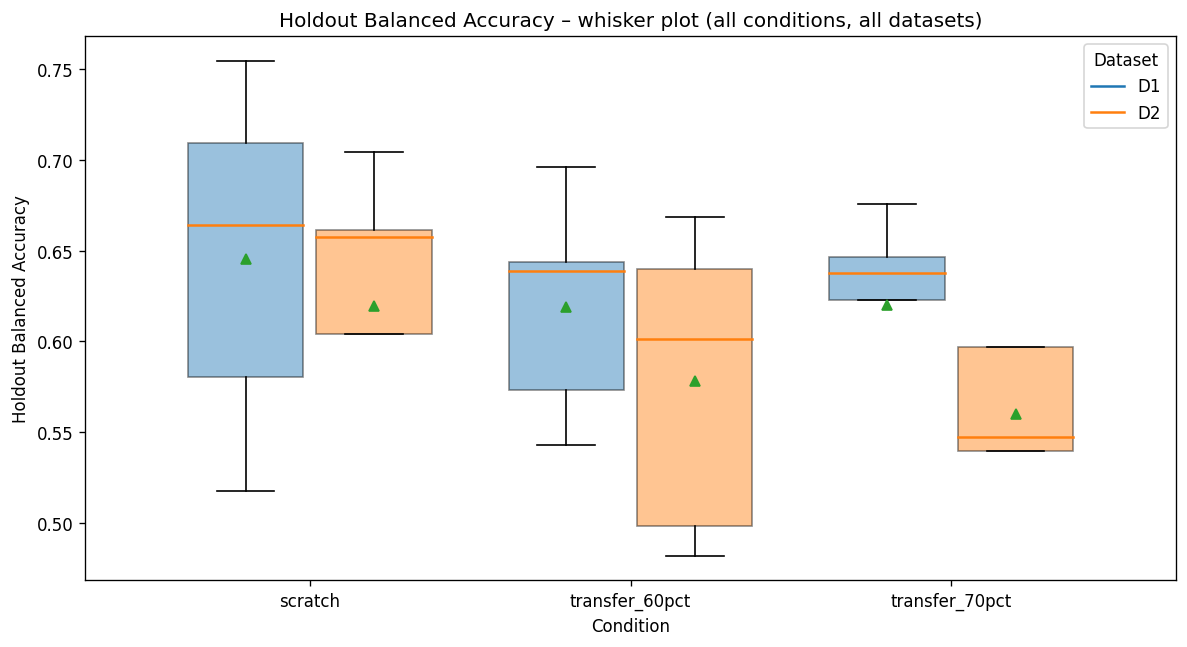

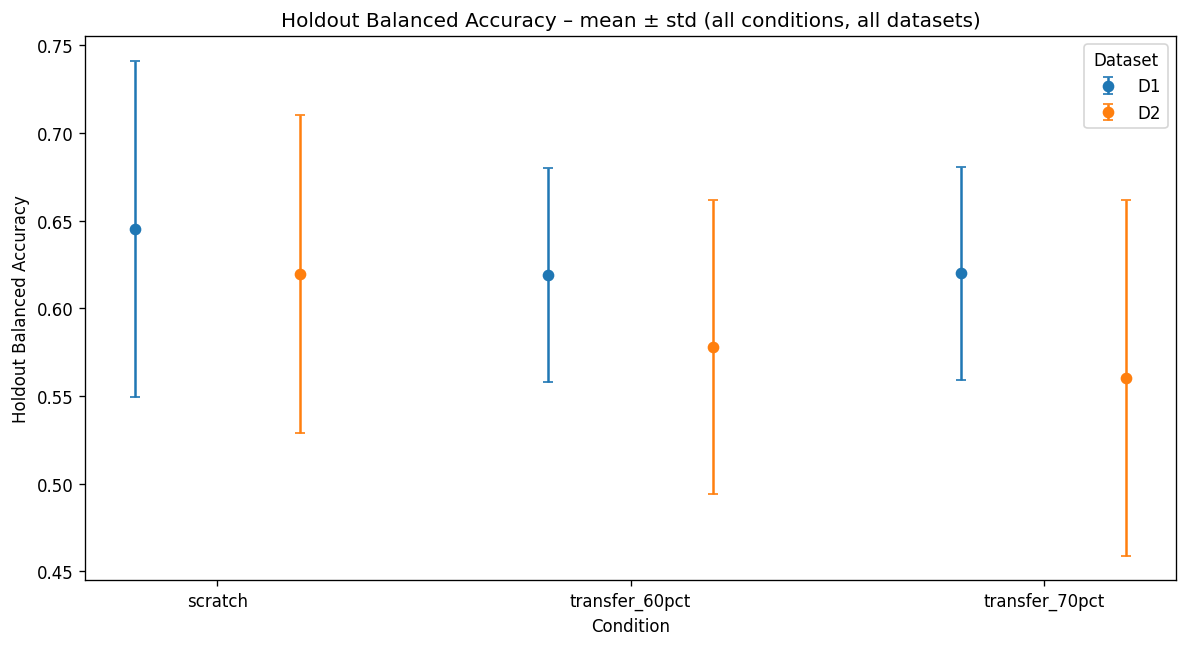

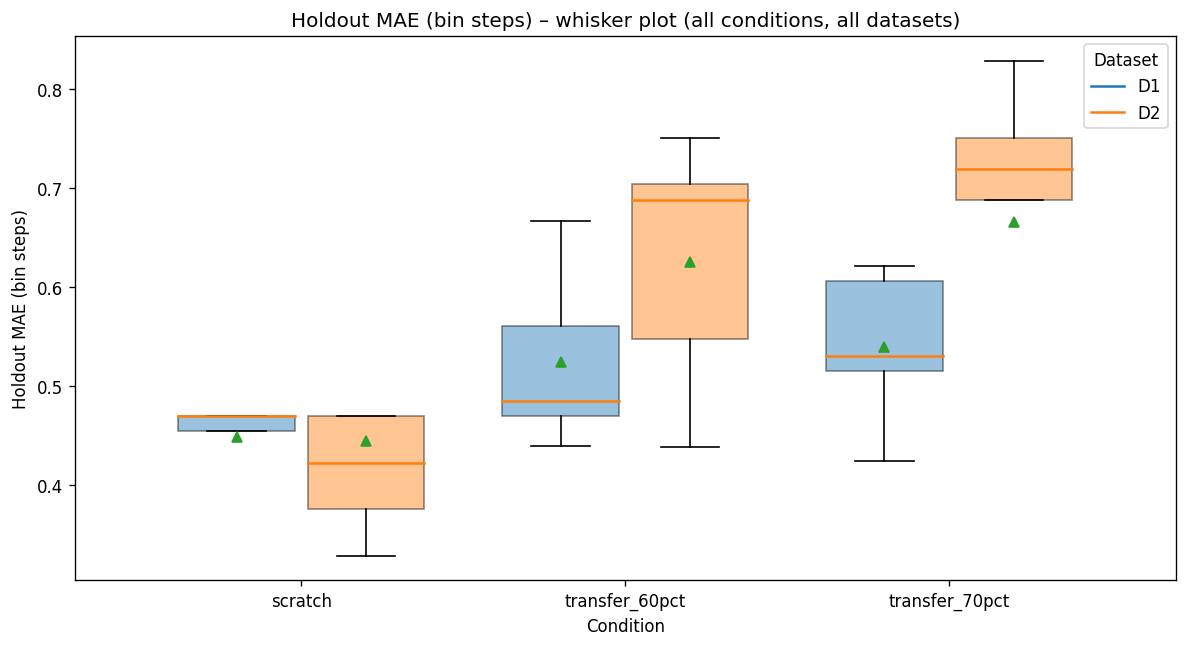

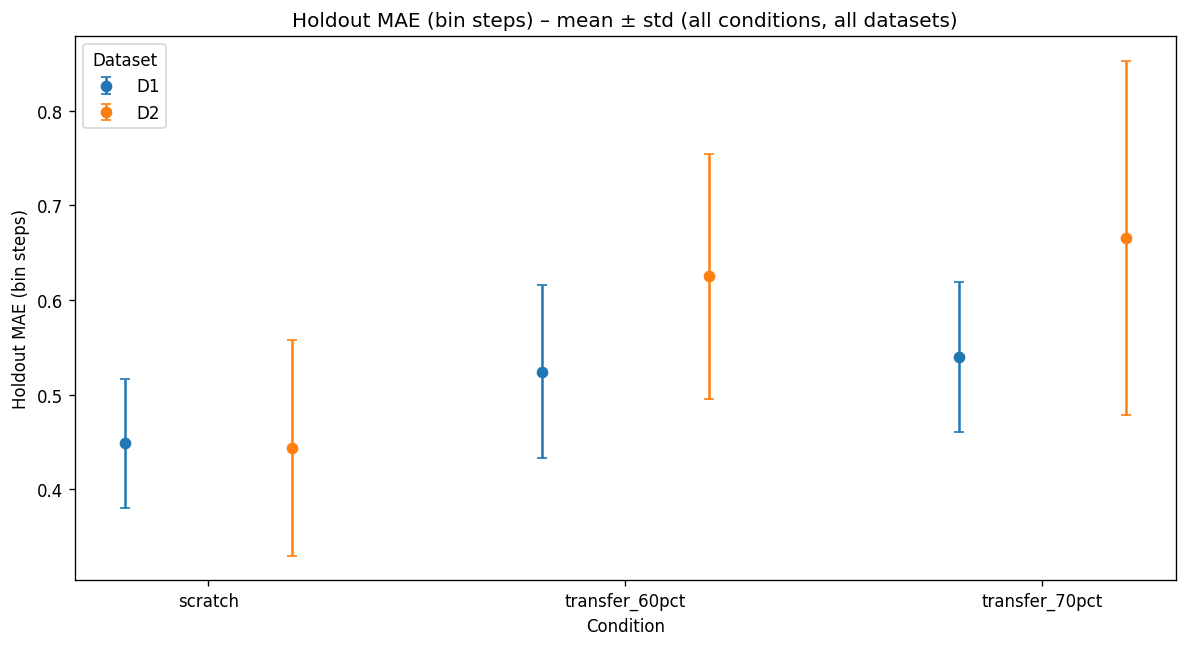

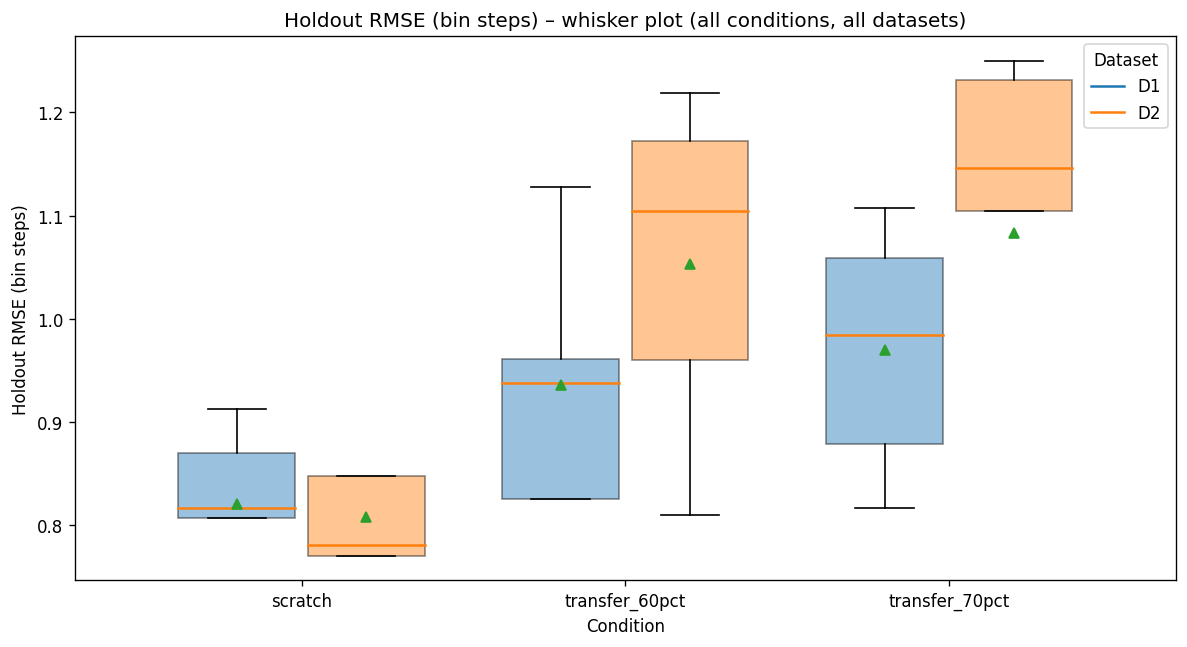

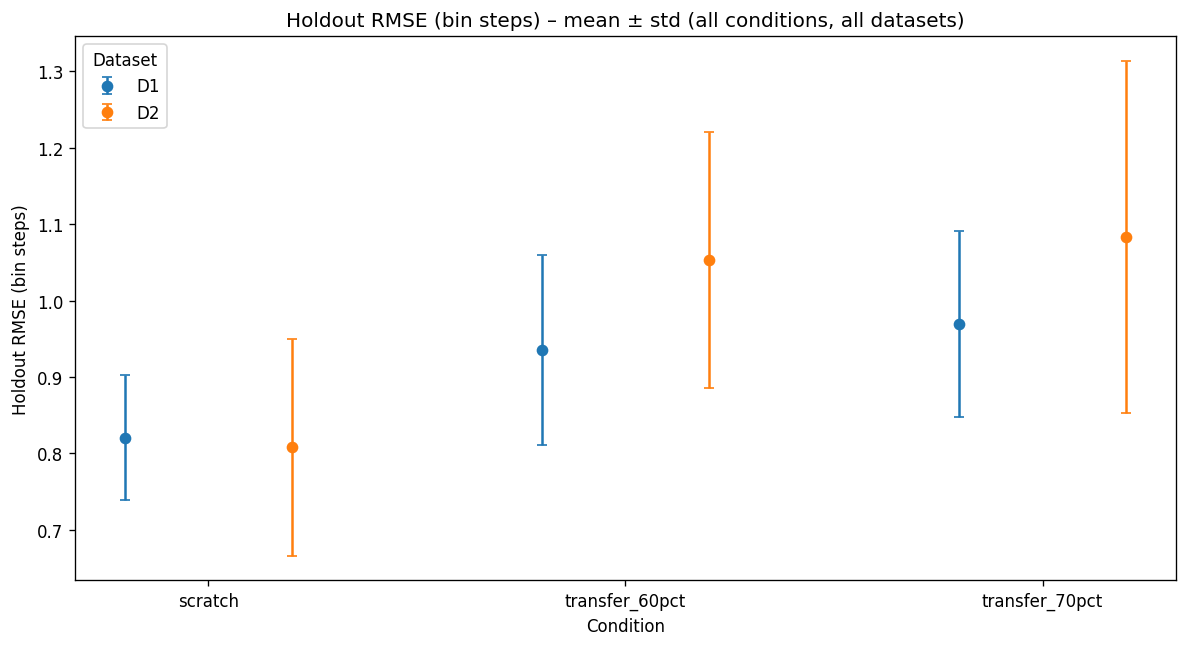


Saved plots to: transfer_learning_model_params/baseline/plots_combined_single


In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ Config ------------------
SUMMARY_CSV = "transfer_learning_model_params/baseline/run_summary_across_seeds_and_pretrain_pct.csv"
OUTDIR = "transfer_learning_model_params/baseline/plots_combined_single"

SCRATCH_LABEL = "scratch"

# (column_name, plot_title, higher_is_better)  # higher_is_better not used here but kept if you want annotations later
METRICS = [
    ("holdout_bacc", "Holdout Balanced Accuracy", True),
    ("holdout_mae_bins", "Holdout MAE (bin steps)", False),
    ("holdout_rmse_bins", "Holdout RMSE (bin steps)", False),
]

SAVE_FIGS = True
SHOW_FIGS = True

plt.rcParams["figure.dpi"] = 120


# ------------------ Helpers ------------------
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def _to_float_or_nan(x):
    try:
        return float(x)
    except Exception:
        return np.nan

def clean(df):
    df = df.copy()

    # normalize pretrain_pct
    df["pretrain_pct"] = df["pretrain_pct"].fillna(SCRATCH_LABEL)
    df["pretrain_pct_str"] = df["pretrain_pct"].astype(str).str.strip().str.lower()

    # numeric pct for sorting/labels
    df["pretrain_pct_num"] = df["pretrain_pct_str"].replace(SCRATCH_LABEL, np.nan).apply(_to_float_or_nan)

    # make a single "condition" label we can plot
    def cond_label(row):
        if row["pretrain_pct_str"] == SCRATCH_LABEL:
            return "scratch"
        # show 0.6 -> 60%
        if pd.notna(row["pretrain_pct_num"]):
            return f"transfer_{int(round(row['pretrain_pct_num']))}pct"
        return f"transfer_{row['pretrain_pct_str']}"

    df["condition"] = df.apply(cond_label, axis=1)

    if "random_state" not in df.columns:
        df["random_state"] = 0

    return df

def condition_order(df):
    """
    scratch first, then transfer in ascending %.
    """
    conds = df["condition"].dropna().unique().tolist()

    scratch = [c for c in conds if c == "scratch"]
    transfers = [c for c in conds if c.startswith("transfer_")]

    def pct_from_cond(c):
        # transfer_60pct -> 60
        s = c.replace("transfer_", "").replace("pct", "")
        try:
            return int(s)
        except Exception:
            return 999999

    transfers_sorted = sorted(transfers, key=pct_from_cond)
    return scratch + transfers_sorted

def dataset_order(df):
    return sorted(df["dataset"].dropna().unique().tolist())


# ------------------ Plotters ------------------
def plot_whisker_single(df, metric, title, outdir=None):
    """
    ONE plot per metric:
      - x axis: condition (scratch, transfer_60pct, transfer_70pct, ...)
      - within each condition: side-by-side boxplots per dataset
    """
    conds = condition_order(df)
    dsets = dataset_order(df)

    # Prepare data as nested lists: [condition][dataset] -> array of values
    values = {}
    for c in conds:
        values[c] = {}
        for d in dsets:
            vals = df.loc[(df["condition"] == c) & (df["dataset"] == d), metric].dropna().values
            values[c][d] = vals

    # Figure
    plt.figure(figsize=(10, 5.5))

    # Layout parameters for grouped boxplots
    n_cond = len(conds)
    n_ds = len(dsets)

    group_x = np.arange(n_cond)  # one group per condition
    total_width = 0.80
    box_width = total_width / max(n_ds, 1)

    # Use default color cycle; each dataset gets one color
    for j, d in enumerate(dsets):
        # positions offset within each group
        positions = group_x - (total_width / 2) + (j + 0.5) * box_width

        data_for_boxes = [values[c][d] for c in conds]

        bp = plt.boxplot(
            data_for_boxes,
            positions=positions,
            widths=box_width * 0.90,
            patch_artist=True,
            showmeans=True,     # mean marker inside box
            showfliers=False,   # optional: hide extreme fliers for readability
        )

        # color boxes for this dataset consistently (matplotlib default color cycle)
        color = f"C{j}"
        for box in bp["boxes"]:
            box.set_facecolor(color)
            box.set_alpha(0.45)

        for med in bp["medians"]:
            med.set_linewidth(1.5)

        # label once per dataset using an invisible line
        plt.plot([], [], color=color, label=d)

    plt.title(f"{title} – whisker plot (all conditions, all datasets)")
    plt.ylabel(title)
    plt.xlabel("Condition")
    plt.xticks(group_x, conds, rotation=0)
    plt.legend(title="Dataset", loc="best")
    plt.tight_layout()

    if outdir:
        plt.savefig(os.path.join(outdir, f"whisker__{metric}.png"))

    if SHOW_FIGS:
        plt.show()
    else:
        plt.close()


def plot_mean_single(df, metric, title, outdir=None):
    """
    ONE plot per metric:
      - x axis: condition
      - within each condition: mean ± std per dataset (offset points with error bars)
    """
    conds = condition_order(df)
    dsets = dataset_order(df)

    # Compute stats
    stats = (
        df.groupby(["dataset", "condition"])[metric]
        .agg(["mean", "std", "count"])
        .reset_index()
    )

    plt.figure(figsize=(10, 5.5))

    n_cond = len(conds)
    n_ds = len(dsets)

    group_x = np.arange(n_cond)
    total_width = 0.80
    point_width = total_width / max(n_ds, 1)

    for j, d in enumerate(dsets):
        color = f"C{j}"
        x = []
        y = []
        yerr = []

        for i, c in enumerate(conds):
            row = stats[(stats["dataset"] == d) & (stats["condition"] == c)]
            if len(row) == 0:
                m, s = np.nan, np.nan
            else:
                m = float(row["mean"].iloc[0])
                s = float(row["std"].iloc[0]) if not pd.isna(row["std"].iloc[0]) else 0.0

            xpos = group_x[i] - (total_width / 2) + (j + 0.5) * point_width
            x.append(xpos)
            y.append(m)
            yerr.append(s)

        plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=3, label=d)

    plt.title(f"{title} – mean ± std (all conditions, all datasets)")
    plt.ylabel(title)
    plt.xlabel("Condition")
    plt.xticks(group_x, conds, rotation=0)
    plt.legend(title="Dataset", loc="best")
    plt.tight_layout()

    if outdir:
        plt.savefig(os.path.join(outdir, f"mean_std__{metric}.png"))

    if SHOW_FIGS:
        plt.show()
    else:
        plt.close()


# ------------------ Main ------------------
def main():
    ensure_dir(OUTDIR)

    df = pd.read_csv(SUMMARY_CSV)
    df = clean(df)

    # Basic guard
    if "dataset" not in df.columns:
        raise ValueError("CSV must contain a 'dataset' column.")
    if "condition" not in df.columns:
        raise ValueError("Condition column not created; check preprocessing.")

    for metric, title, _hib in METRICS:
        if metric not in df.columns:
            print(f"[WARN] Missing column '{metric}' – skipping")
            continue

        # Whisker (box) plot: ALL balanced acc (or MAE / RMSE) on one plot
        plot_whisker_single(df, metric, title, outdir=OUTDIR if SAVE_FIGS else None)

        # Mean ± std plot: ALL conditions on one plot
        plot_mean_single(df, metric, title, outdir=OUTDIR if SAVE_FIGS else None)

    if SAVE_FIGS:
        print(f"\nSaved plots to: {OUTDIR}")


if __name__ == "__main__":
    main()


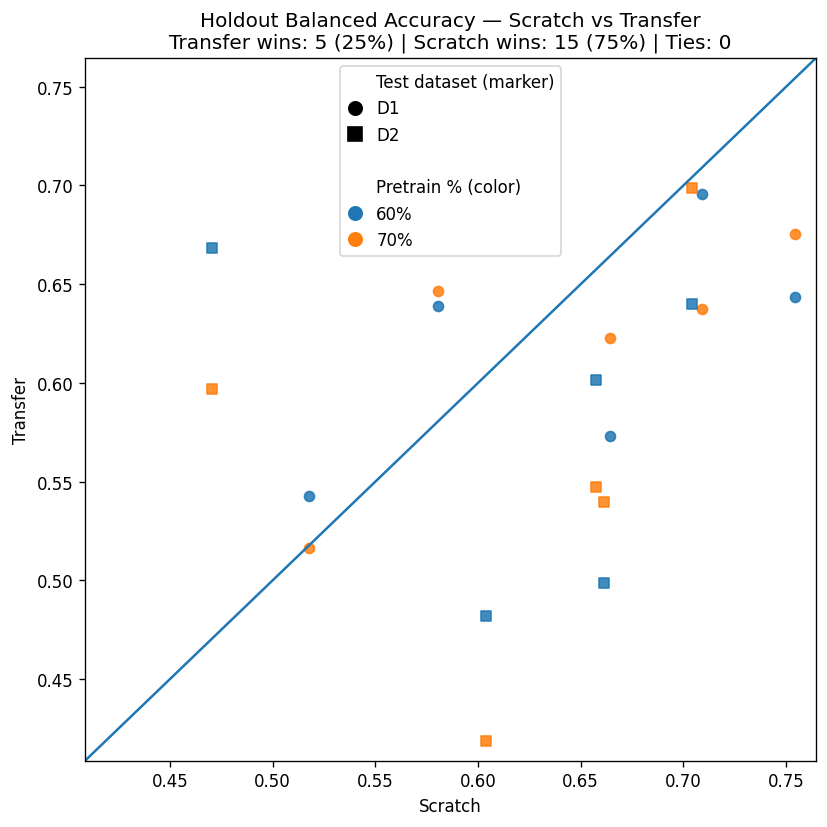

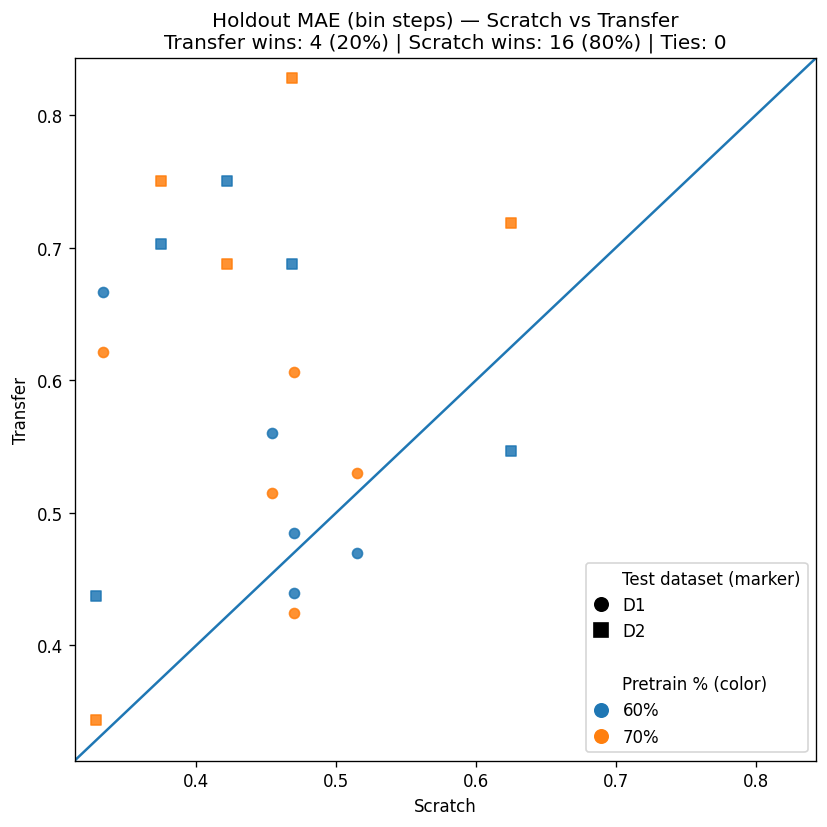

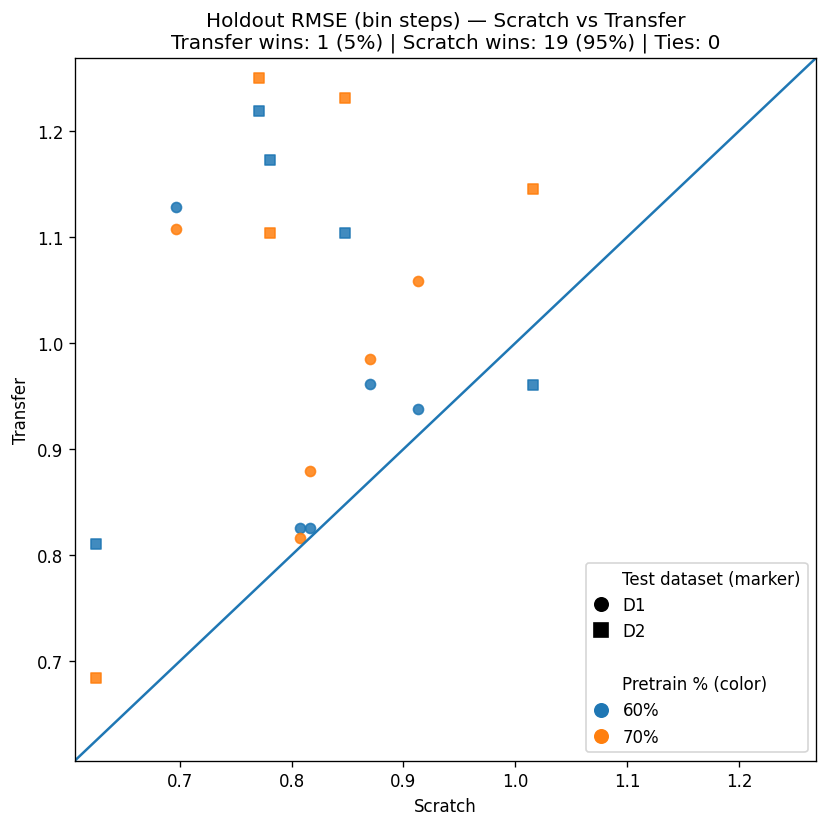


Saved VS plots to: transfer_learning_model_params/baseline/plots_vs_only


In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ------------------ Config ------------------
SUMMARY_CSV = "transfer_learning_model_params/baseline/run_summary_across_seeds_and_pretrain_pct.csv"
OUTDIR = "transfer_learning_model_params/baseline/plots_vs_only"

SCRATCH_LABEL = "scratch"

METRICS = [
    ("holdout_bacc", "Holdout Balanced Accuracy", True),
    ("holdout_mae_bins", "Holdout MAE (bin steps)", False),
    ("holdout_rmse_bins", "Holdout RMSE (bin steps)", False),
]

SAVE_FIGS = True
SHOW_FIGS = True

plt.rcParams["figure.dpi"] = 120


# ------------------ Helpers ------------------
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)


def _to_float_or_nan(x):
    try:
        return float(x)
    except Exception:
        return np.nan


def clean(df):
    df = df.copy()

    df["pretrain_pct"] = df["pretrain_pct"].fillna(SCRATCH_LABEL)
    df["pretrain_pct_str"] = df["pretrain_pct"].astype(str).str.lower()
    df["pretrain_pct_num"] = (
        df["pretrain_pct_str"]
        .replace(SCRATCH_LABEL, np.nan)
        .apply(_to_float_or_nan)
    )

    def cond_label(row):
        if row["pretrain_pct_str"] == SCRATCH_LABEL:
            return "scratch"
        return f"transfer_{int(round(row['pretrain_pct_num']))}pct"

    df["condition"] = df.apply(cond_label, axis=1)

    if "random_state" not in df.columns:
        df["random_state"] = 0

    return df


def paired_table(df, metric):
    scratch = (
        df[df["condition"] == "scratch"]
        [["dataset", "random_state", metric]]
        .rename(columns={metric: "scratch"})
        .drop_duplicates()
    )

    transfer = (
        df[df["condition"] != "scratch"]
        [["dataset", "random_state", "condition", metric]]
        .rename(columns={metric: "transfer"})
        .drop_duplicates()
    )

    paired = transfer.merge(
        scratch,
        on=["dataset", "random_state"],
        how="inner",
    )

    return paired


def compute_vs_counts(paired, higher_is_better):
    if higher_is_better:
        transfer_wins = (paired["transfer"] > paired["scratch"]).sum()
        scratch_wins = (paired["transfer"] < paired["scratch"]).sum()
    else:
        transfer_wins = (paired["transfer"] < paired["scratch"]).sum()
        scratch_wins = (paired["transfer"] > paired["scratch"]).sum()

    ties = (paired["transfer"] == paired["scratch"]).sum()
    total = len(paired)

    return {
        "transfer": int(transfer_wins),
        "scratch": int(scratch_wins),
        "ties": int(ties),
        "total": int(total),
        "transfer_pct": (transfer_wins / total) if total else 0.0,
        "scratch_pct": (scratch_wins / total) if total else 0.0,
    }


# ------------------ VS Plot ------------------
def plot_vs_single(paired, metric_title, higher_is_better, outdir=None):
    """
    Single VS plot per metric:
      x = scratch
      y = transfer
      color = pretrain %
      marker = TEST / EVALUATION dataset
    """
    if paired.empty:
        print("[WARN] No paired rows found — skipping VS plot.")
        return

    test_datasets = sorted(paired["dataset"].unique())
    conditions = sorted(
        paired["condition"].unique(),
        key=lambda c: int(c.replace("transfer_", "").replace("pct", ""))
    )

    markers = ["o", "s", "^", "D", "P", "X"]
    ds_marker = {d: markers[i % len(markers)] for i, d in enumerate(test_datasets)}
    cond_color = {c: f"C{i}" for i, c in enumerate(conditions)}

    counts = compute_vs_counts(paired, higher_is_better)

    plt.figure(figsize=(7, 7))

    for d in test_datasets:
        for c in conditions:
            g = paired[(paired["dataset"] == d) & (paired["condition"] == c)]
            if g.empty:
                continue

            plt.scatter(
                g["scratch"],
                g["transfer"],
                marker=ds_marker[d],
                color=cond_color[c],
                alpha=0.85,
            )

    # Diagonal
    vals = np.r_[paired["scratch"].values, paired["transfer"].values]
    lo, hi = np.nanmin(vals), np.nanmax(vals)
    pad = 0.03 * (hi - lo)
    plt.plot([lo - pad, hi + pad], [lo - pad, hi + pad])
    plt.xlim(lo - pad, hi + pad)
    plt.ylim(lo - pad, hi + pad)

    plt.xlabel("Scratch")
    plt.ylabel("Transfer")
    plt.title(
        f"{metric_title} — Scratch vs Transfer\n"
        f"Transfer wins: {counts['transfer']} ({counts['transfer_pct']:.0%}) | "
        f"Scratch wins: {counts['scratch']} ({counts['scratch_pct']:.0%}) | "
        f"Ties: {counts['ties']}"
    )

    # ---- Single combined legend ----
    legend_handles = []
    legend_labels = []

    legend_handles.append(Line2D([], [], linestyle="none"))
    legend_labels.append("Test dataset (marker)")

    for d in test_datasets:
        legend_handles.append(
            Line2D([], [], linestyle="none", marker=ds_marker[d], color="black", markersize=8)
        )
        legend_labels.append(str(d))

    legend_handles.append(Line2D([], [], linestyle="none"))
    legend_labels.append("")

    legend_handles.append(Line2D([], [], linestyle="none"))
    legend_labels.append("Pretrain % (color)")

    for c in conditions:
        lbl = c.replace("transfer_", "").replace("pct", "%")
        legend_handles.append(
            Line2D([], [], linestyle="none", marker="o", color=cond_color[c], markersize=8)
        )
        legend_labels.append(lbl)

    plt.legend(
        legend_handles,
        legend_labels,
        loc="best",
        frameon=True,
        handlelength=1.0,
    )

    plt.tight_layout()

    if outdir:
        fname = metric_title.replace(" ", "_").lower()
        plt.savefig(os.path.join(outdir, f"vs__{fname}.png"))

    if SHOW_FIGS:
        plt.show()
    else:
        plt.close()


# ------------------ Main ------------------
def main():
    ensure_dir(OUTDIR)

    df = pd.read_csv(SUMMARY_CSV)
    df = clean(df)

    for metric, title, hib in METRICS:
        if metric not in df.columns:
            continue

        paired = paired_table(df, metric)
        plot_vs_single(paired, title, hib, outdir=OUTDIR if SAVE_FIGS else None)

    if SAVE_FIGS:
        print(f"\nSaved VS plots to: {OUTDIR}")


if __name__ == "__main__":
    main()
